In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
# Función para invertir la transformación de escala
def invTransform(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

In [3]:
df_Hospedajes = pd.read_excel('../data_out/Hospedajes_RD-CLEANED.xlsx')

In [4]:
df_Hospedajes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5038 entries, 0 to 5037
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   ID_ALOJAMIENTO               5038 non-null   int64 
 1   TITULO_ALOJAMIENTO           5038 non-null   object
 2   TIPO_ALOJAMIENTO             5038 non-null   object
 3   ESPACIO_ALOJAMIENTO          5038 non-null   object
 4   UBICACION                    5038 non-null   object
 5   PRECIO_USD                   5038 non-null   object
 6   MAX_HUESPEDES                5038 non-null   object
 7   CANTIDAD_HABITACIONES        5038 non-null   object
 8   CANTIDAD_CAMAS               5038 non-null   object
 9   CANTIDAD_BAÑOS               5038 non-null   object
 10  ES_SUPER_ANFITRION           5038 non-null   int64 
 11  CANTIDAD_EVALUACIONES        5038 non-null   object
 12  CALIFICACION_GENERAL         5038 non-null   object
 13  CALIFICACION_LIMPIEZA        5038

# Imputacion de valores numericos y categoricos

In [5]:
# Convertir "No encontrado" a NaN
df_Hospedajes.replace("No encontrado", None, inplace=True)

# Eliminar las columnas ID y TITULO_ALOJAMIENTO
df_Hospedajes.drop(columns=['TITULO_ALOJAMIENTO'], inplace=True)

# Definir las columnas numéricas y categóricas
numerical_columns = ['ID_ALOJAMIENTO','PRECIO_USD', 'MAX_HUESPEDES', 'CANTIDAD_HABITACIONES', 'CANTIDAD_CAMAS', 'CANTIDAD_BAÑOS',
                     'ES_SUPER_ANFITRION', 'CANTIDAD_EVALUACIONES', 'CALIFICACION_GENERAL', 'CALIFICACION_LIMPIEZA',
                     'CALIFICACION_VERACIDAD', 'CALIFICACION_LLEGADA', 'CALIFICACION_COMUNICACION',
                     'CALIFICACION_UBICACION', 'CALIFICACION_CALIDAD_PRECIO','FLAG_RESERV_INMEDIATA','FLAG_LLEGADA_AUTONOMA','FLAG_CANCELAC_GRATUITA','FLAG_ACEPT_MASCOTAS']

categorical_columns = ['TIPO_ALOJAMIENTO','ESPACIO_ALOJAMIENTO', 'UBICACION']

# Convertir las columnas numéricas a tipo float
for column in numerical_columns:
    df_Hospedajes[column] = df_Hospedajes[column].astype(float)

In [6]:
# Crear el preprocesador para OneHotEncoding y StandardScaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'
)

In [7]:
# Crear un pipeline que incluye preprocesamiento y KNNImputer
pipeline_preprocessor = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

pipeline_imputer = Pipeline(steps=[
    ('imputer', KNNImputer())
])

In [8]:
# Aplicar el preprocesamiento
df_preprocessed = pipeline_preprocessor.fit_transform(df_Hospedajes)

In [9]:
# Obtener nombres de las columnas después de OneHotEncoding
cat_cols_encoded = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
all_cols_preprocessed = list(preprocessor.named_transformers_['num'].get_feature_names_out()) + list(cat_cols_encoded) + [col for col in df_Hospedajes.columns if col not in numerical_columns + categorical_columns]


In [10]:
# Convertir el resultado preprocesado de nuevo a DataFrame
df_preprocessed = pd.DataFrame(df_preprocessed, columns=all_cols_preprocessed)

In [11]:
# Definir la rejilla de parámetros para buscar el mejor n_neighbors
param_grid = {
    'imputer__n_neighbors': [3, 5, 7, 9, 11]
}

In [12]:
# Usar GridSearchCV para encontrar el mejor parámetro
search = GridSearchCV(pipeline_imputer, param_grid, cv=5, scoring='neg_mean_squared_error')
search.fit(df_preprocessed)

c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() mis

GridSearchCV(cv=5, estimator=Pipeline(steps=[('imputer', KNNImputer())]),
             param_grid={'imputer__n_neighbors': [3, 5, 7, 9, 11]},
             scoring='neg_mean_squared_error')

In [13]:
# Obtener el mejor parámetro y la imputación final
best_n_neighbors = search.best_params_['imputer__n_neighbors']
print(f"Mejor valor de n_neighbors: {best_n_neighbors}")

Mejor valor de n_neighbors: 3


In [14]:
# Imputar el conjunto de datos completo utilizando el mejor parámetro
pipeline_imputer.set_params(imputer__n_neighbors=best_n_neighbors)
df_imputed = pipeline_imputer.fit_transform(df_preprocessed)

In [15]:
# Convertir el resultado imputado de nuevo a DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=all_cols_preprocessed)

In [16]:
# Revertir el escalado de las columnas numéricas utilizando la función invTransform
scaler = preprocessor.named_transformers_['num']
for col in numerical_columns:
    df_imputed[col] = invTransform(scaler, df_imputed[col], col, numerical_columns)

In [17]:
# Analizar los datos antes y después de la imputación
missing_before = df_preprocessed.isnull().mean() * 100
missing_after = df_imputed.isnull().mean() * 100

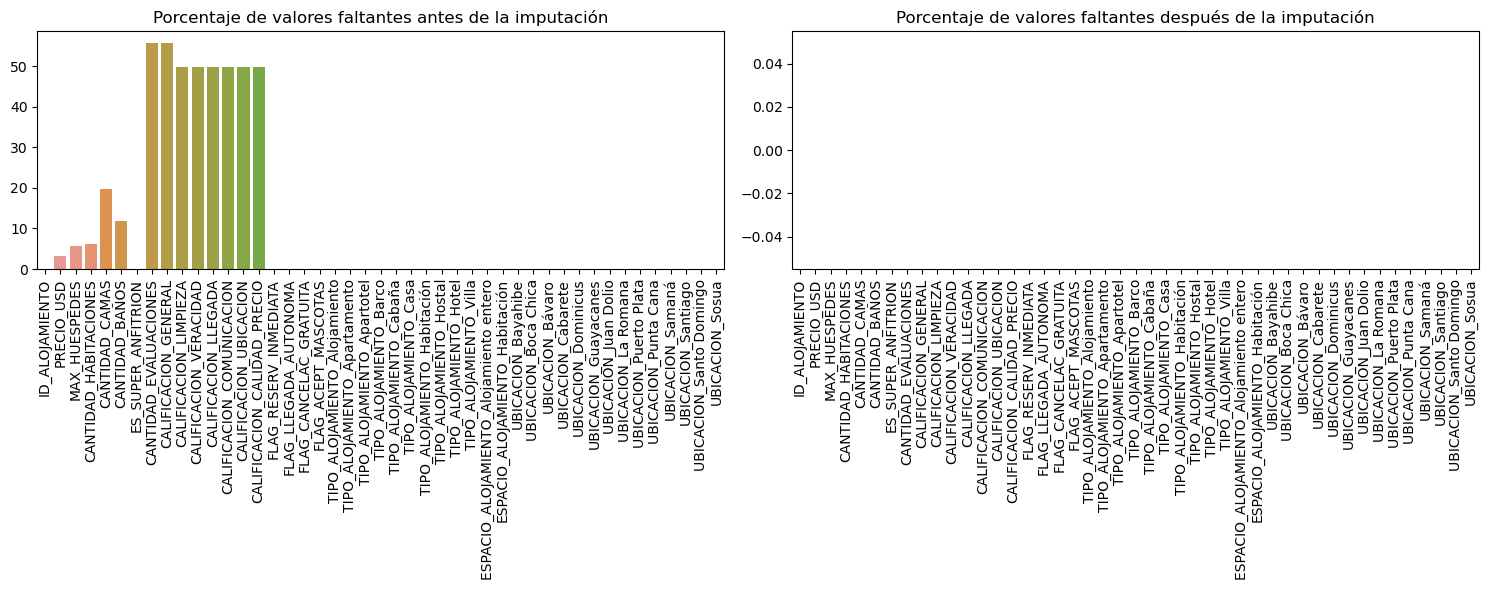

In [18]:
# Graficar los valores faltantes antes y después de la imputación
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(x=missing_before.index, y=missing_before.values, ax=ax[0])
ax[0].set_title('Porcentaje de valores faltantes antes de la imputación')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
sns.barplot(x=missing_after.index, y=missing_after.values, ax=ax[1])
ax[1].set_title('Porcentaje de valores faltantes después de la imputación')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

In [19]:
# Calcular y mostrar métricas de imputación
mse = mean_squared_error(df_preprocessed[numerical_columns].fillna(0), df_imputed[numerical_columns])
print(f'Error cuadrático medio (MSE) de la imputación: {mse}')

Error cuadrático medio (MSE) de la imputación: 3.0658678543121767e+34


In [20]:
# Calcular y mostrar métricas de imputación por cada variable numérica
mse_per_variable = {}
for col in numerical_columns:
    mse = mean_squared_error(df_preprocessed[col].fillna(0), df_imputed[col])
    mse_per_variable[col] = mse
    print(f'Error cuadrático medio (MSE) de la imputación para {col}: {mse}')

Error cuadrático medio (MSE) de la imputación para ID_ALOJAMIENTO: 5.825148923193137e+35
Error cuadrático medio (MSE) de la imputación para PRECIO_USD: 316757.6378502085
Error cuadrático medio (MSE) de la imputación para MAX_HUESPEDES: 31.09909736326636
Error cuadrático medio (MSE) de la imputación para CANTIDAD_HABITACIONES: 5.97845194151496
Error cuadrático medio (MSE) de la imputación para CANTIDAD_CAMAS: 11.896332224961077
Error cuadrático medio (MSE) de la imputación para CANTIDAD_BAÑOS: 4.7495322318058415
Error cuadrático medio (MSE) de la imputación para ES_SUPER_ANFITRION: 0.38197401076900844
Error cuadrático medio (MSE) de la imputación para CANTIDAD_EVALUACIONES: 2009.9021970381204
Error cuadrático medio (MSE) de la imputación para CALIFICACION_GENERAL: 22.603004167199565
Error cuadrático medio (MSE) de la imputación para CALIFICACION_LIMPIEZA: 22.66224032752514
Error cuadrático medio (MSE) de la imputación para CALIFICACION_VERACIDAD: 22.824523435616314
Error cuadrático medi

In [15]:
# Guardar el DataFrame imputado
df_imputed.to_excel('../data_out/Hospedajes_RD-IMPUTED V2.xlsx', index=False)